# Rearranger

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import tkinter as tk
from tkinter import filedialog
from pathlib import Path
from functools import partial, wraps

In [ ]:
root = tk.Tk()
root.withdraw()

# Open dialog to choose the .txt file
file_type = [('Text File', '*.txt')]
default_dir = 'Input'
file_path = filedialog.askopenfilename(filetypes=file_type, initialdir=default_dir)

# Read the .txt file into a dataframe
raw_df = pd.read_csv(file_path, sep = "\t")

raw_df.head()


In [ ]:
# Remove unnecessary columns
for col in raw_df.columns:
    if "unnamed" in col.lower() or "prob" in col.lower():
        raw_df.drop(col, axis=1, inplace=True)

raw_df

In [ ]:
# Extract the first frame of the video to get a sample image

# Open dialog to choose the .mp4 file
file_type = [('Video File', '*.mp4')]
default_dir = 'Input'
file_path = filedialog.askopenfilename(filetypes=file_type, initialdir=default_dir)
video_P = Path(file_path)

cap = cv2.VideoCapture(file_path)
_, frame = cap.read()
cap.release()

# Export frame as a .png file
image_P = video_P.parent / (video_P.stem + ".png")
cv2.imwrite(str(image_P), frame)


In [ ]:
def get_tanks(im):
    example_tanks = {}

    tank_names = ['Top Left', 'Top Right', 'Bottom Left']

    def tank_selector(im, tank_name):
        while True:
            selected_pixel = cv2.selectROI('Selecting tank at position'+str(tank_name), im)
            
            # print out the coordinates of top left and bottom right pixel of the ROI
            print('Tank at position: ', tank_name)
            print('Top left pixel: x = {}, y = {}'.format(selected_pixel[0], selected_pixel[1]))
            print('Bottom right pixel: x = {}, y = {}'.format(selected_pixel[0] + selected_pixel[2], selected_pixel[1] + selected_pixel[3]))
            print('Middle line: y = {}'.format(selected_pixel[1] + selected_pixel[3] / 2))
            tank_d = math.ceil((selected_pixel[2] + selected_pixel[3]) / 2)
            print('Diameter of the tank : ', tank_d)
            print()
            example_tanks[tank_name] = selected_pixel
            cv2.destroyAllWindows()
            break

    for name in tank_names:
        tank_selector(im, name)

    return example_tanks

In [ ]:
image_P = Path(r"C:\Code\ChungyuanProjects\TowerAssayAnalyzer\Input\Zebrafish Tower\A - Novel Tank Test\01 - Control (1st Batch).png")


In [ ]:

im = cv2.imread(str(image_P))
example_wells = get_tanks(im)

In [ ]:
tanks_col = 5
tanks_row = 2

# tanks number
# 10 9 8 7 6
# 5 4 3 2 1

tanks_dict = {}

TL_num = tanks_col * tanks_row
TR_num = TL_num - tanks_col + 1
BL_num = tanks_col

tanks_dict[TL_num] = example_wells['Top Left']
tanks_dict[TR_num] = example_wells['Top Right']
tanks_dict[BL_num] = example_wells['Bottom Left']
tanks_dict[1] = (tanks_dict[6][0] - (tanks_dict[10][0] - tanks_dict[5][0]), tanks_dict[6][1] - (tanks_dict[10][1] - tanks_dict[5][1]), tanks_dict[6][2]*(tanks_dict[5][2]/tanks_dict[10][2]), tanks_dict[6][3]*(tanks_dict[5][3]/tanks_dict[10][3]))

def fill_row(tanks_dict, start, end, display = True):
    x_sep = (tanks_dict[start][0] - tanks_dict[end][0])/(end - start)
    y_sep = (tanks_dict[start][1] - tanks_dict[end][1])/(end - start)
    w_sep = (tanks_dict[start][2] - tanks_dict[end][2])/(end - start)
    h_sep = (tanks_dict[start][3] - tanks_dict[end][3])/(end - start)

    for i in range(start+1, end):
        tanks_dict[i] = (tanks_dict[end][0] + x_sep*(end-i), tanks_dict[end][1] + y_sep*(end-i), tanks_dict[end][2] + w_sep*(end-i), tanks_dict[end][3] + h_sep*(end-i))
    
    if display:
        for key, value in locals().items():
            print(key + ' = ' + str(value))

    return tanks_dict

for row in range(0, tanks_row):
    tanks_dict = fill_row(tanks_dict, 1 + row*tanks_col, (row+1)*tanks_col)
    # row = 0, fill(tanks_dict, 1 + 0*5,  (0+1)*5)
    # row = 1, fill(tanks_dict, 1 + 1*5,  (1+1)*5)

# tanks_dict = fill_row(tanks_dict, 1, 5)
# tanks_dict = fill_row(tanks_dict, 6, 10)

# round up all the values in tanks_dict to integers
for key in tanks_dict:
    tanks_dict[key] = tuple([int(round(i)) for i in tanks_dict[key]])

tanks_dict


In [ ]:
im = cv2.imread(str(image_P))

# Display predicted tanks
def display_tanks():
    for i in range(1, 11):
        x, y, w, h = tanks_dict[i]
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(im, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Tanks', im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

display_tanks()


In [ ]:
import random
from Libs.misc import display_coords

def coord_generator(box, points = 1000):
    x, y, w, h = box
    coords = []
    for i in range(points):
        x_coord = random.randint(x, x+w)
        y_coord = random.randint(y, y+h)
        coords.append((x_coord, y_coord))
    return coords

def mix_up(input_dict, mix_ratio = 0.3):
    # input_dict has 10 keys 
    # keys are 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
    # values are coordinates inside the tanks
    # mix_ratio is the ratio of mixing up the coordinates
    # mix_ratio = 0.3 means 30% of the coordinates will be mixed up

    for i in range(1, len(input_dict)+1):
        if i == 1:
            continue
        else:
            for j in range(1, len(input_dict[i])+1):
                if random.random() < mix_ratio:
                    # swap the coordinates
                    input_dict[i][j-1], input_dict[i-1][j-1] = input_dict[i-1][j-1], input_dict[i][j-1]
    return input_dict
                    
def mix_up_df(input_df, mix_ratio = 0.3):

    for i in range(1, len(input_df.columns)+1, 2):
        if i == 1:
            continue
        else:
            for j in range(1, len(input_df)+1):
                if random.random() < mix_ratio:
                    # swap the coordinates
                    input_df.iloc[j-1, i-1], input_df.iloc[j-1, i-2] = input_df.iloc[j-1, i-2], input_df.iloc[j-1, i-1]

    return input_df

test_dict = {}
for i in range(1, 11):
    test_dict[i] = coord_generator(tanks_dict[i])


columns = []
for i in range (1, 11):
    columns.append('x' + str(i))
    columns.append('y' + str(i))

test_df = pd.DataFrame(columns = columns)
for i in range(1, 11):
    test_df['x' + str(i)] = [x for x, y in test_dict[i]]
    test_df['y' + str(i)] = [y for x, y in test_dict[i]]

test_df

In [ ]:
display_coords(test_df, im)

In [ ]:
mixed_dict = mix_up(test_dict, mix_ratio = 0.3)
mixed_dict

# turn test_dict into dataframe, with 20 columns
# columns = ['x1', 'y1', 'x2', 'y2', ..., 'x10', 'y10']
# rows = 1000

import pandas as pd



mixed_df = pd.DataFrame(columns = columns)
for i in range(1, 11):
    mixed_df['x' + str(i)] = [x for x, y in mixed_dict[i]]
    mixed_df['y' + str(i)] = [y for x, y in mixed_dict[i]]

mixed_df

In [ ]:
display_coords(mixed_df, im)

In [ ]:
cv2.imshow('Tanks', im)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def in_box(input_x, input_y, box):
    x, y, w, h = box
    return x <= input_x <= x + w and y <= input_y <= y + h
    
def in_which_tank(x, y):
    for tank_num, tank_box in tanks_dict.items():
        if in_box(x, y, tank_box):
            return tank_num
    return -1

true_df = pd.DataFrame(columns=test_df.columns)
for idx, row in test_df.iterrows():
    for j in range(1, 11):
        x = row['x' + str(j)]
        y = row['y' + str(j)]
        
        tank = in_which_tank(x, y)

        if tank != -1:
            true_df.loc[idx, 'x' + str(j)] = x
            true_df.loc[idx, 'y' + str(j)] = y     

true_df

In [ ]:
display_coords(true_df, im)

In [ ]:
from Libs.misc import load_threshold

threshold_path = 'Bin/thresholds.json'

speed1, speed2 = load_threshold(threshold_path, 'SPEED_1', 'SPEED_2')

speed1, speed2

In [ ]:
from Libs.misc import get_file_path, load_raw_df, clean_df

file_type = [('Text File', '*.txt')]
default_dir = 'Input'
txt_path = get_file_path(file_type, default_dir)

raw_df, tanks_list = load_raw_df(txt_path)

raw_df, _ = clean_df(raw_df, fill = True)

raw_df.head()


In [ ]:
# export to a csv file
raw_df.to_csv('Output/raw_df_withgap.csv', index = False)

In [ ]:
from Libs.misc import display_coords, get_image

im, _ = get_image(source = 'image')
display_coords(raw_df, im, window_name = "Fish 3", tanks_list = tanks_list)


In [ ]:
from Libs.analyzer import NovelTankTest

nvtt1 = NovelTankTest(raw_df)

summary_dict = nvtt1.basiccal()

summary_dict

In [ ]:
int(15.3)

In [ ]:
from Libs.misc import *

final_df, im, tanks_list = draw_prep()

In [ ]:
draw_trajectories(final_df, im, tanks_list, until = 3000)

In [ ]:
from Libs.misc import *

final_df_1, im_1, tanks_list_1 = draw_prep(mode = 'single')

In [ ]:
import time
import cv2

time_range = [200, 250]

time = time_range[0]
while True:
    print('Time frame: ', time)
    draw_trajectories(final_df_1, im_1, tanks_list_1, until = time, wait = 5)
    time += 1
    cv2.waitKey(1)
    # If "spacebar" is pressed, pause the video
    if cv2.waitKey(1) & 0xFF == ord(' '):
        cv2.waitKey(0)
    if time == time_range[1] or cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
for time in range(200, 250):
    draw_trajectories(final_df_1, im_1, tanks_list_1, until = time, wait = 5)
    # if a key is pressed, pause the video
cv2.waitKey(0)
cv2.destroyAllWindows()

# draw_trajectories(final_df_1, im_1, tanks_list_1, until = 230)

In [ ]:
import numpy as np
import pandas as pd

# create an example dataframe with column X Y
# in X there are some Nan values, along with int values
# in Y there are some Nan values, along with int values

df = pd.DataFrame({'X': [1, 2, 3, np.nan, 5, np.nan, 7, 8, 9, 10],
                     'Y': [1, 2, 3, 4, 5, 6, 7, 8, 9, np.nan]})

# find nan in X
nan_coords = np.where(df['X'].isnull())[0]
len(nan_coords)

In [ ]:
my_array = [1, 2, 3, 4, 7, 8, 9, 15, 16, 17]

# turn it into numpy array
my_array = np.array(my_array)

# split my_array into groups of continous numbers, sep = 1
# output = [[1, 2, 3, 4], [7, 8, 9], [15, 16, 17]]

def split_array(my_array, sep = 1):
    # get the difference between each number
    diff = np.diff(my_array)
    # get the index of the difference that is larger than sep
    split_index = np.where(diff > sep)[0]
    # split the array into groups
    split_array = np.split(my_array, split_index + 1)
    return split_array

split_array(my_array)

In [ ]:
import torch

# test cuda
torch.cuda.is_available()


In [1]:
from Libs.analyzer import *
import pandas as pd

total_csv_path = r'D:\Code\TowerAssayAnalyzer\Output\arranged_C - Mirror Biting Test - full.csv'

total_df = pd.read_csv(total_csv_path)

# get the first tank
first_tank_df = total_df[['X1', 'Y1']].copy()

NTT_Tank1 = NovelTankTest(first_tank_df)

In [4]:
NTT_Tank1.distance.variables(magic = False)

['avg', 'list', 'total', 'unit']

## Testing the noveltanktest class

In [10]:
from Libs.misc import load_raw_df, clean_df
from Libs.executor import *

txt_path = "Input/Zebrafish Tower/A - Novel Tank Test/trajectories.txt"
df, _ = load_raw_df(txt_path)
df, _ = clean_df(df, fill = True)

display_dict = NovelTank_Display(df).rows

for key, value in display_dict.items():
    print(key, value)

           X1      Y1
0      1109.4  683.28
1      1109.1  682.17
2      1108.3  682.42
3      1108.2  681.94
4      1107.6  682.40
...       ...     ...
21234  1163.3  411.49
21235  1163.3  411.97
21236  1163.0  412.45
21237  1162.6  413.22
21238  1162.3  414.01

[21239 rows x 2 columns]


0 ['total distance', nan, 'cm']
1 ['average speed', nan, 'cm/s']
2 ['freezing percentage', 3.051134758451832, '%']
3 ['swimming percentage', 80.93511630096995, '%']
4 ['Distance to center', nan, 'cm']
5 ['Time in top', 48.64635811478883, 'seconds']
6 ['Time in bottom', 51.35364188521117, 'seconds']
7 ['Time spent in top/bottom ratio', nan, '']
8 ['Distance traveled in top', 76280.12131301702, 'cm']
9 ['Distance traveled top/bottom ratio', nan, '']
10 ['Latency in frames', 9, 'frames']
11 ['Latency in seconds', 0.18, 'seconds']


## Testing the shoalingtest class

In [14]:
from Libs.misc import load_raw_df, clean_df
from Libs.executor import *

txt_path = "Input/Zebrafish Tower/A - Novel Tank Test/trajectories.txt"
whole_df, _ = load_raw_df(txt_path)
whole_df, _ = clean_df(whole_df, fill=True)
df1, df2, df3 = whole_df.iloc[:, :2], whole_df.iloc[:, 2:4], whole_df.iloc[:, 4:]

whole_df

NameError: name 'clean_df' is not defined

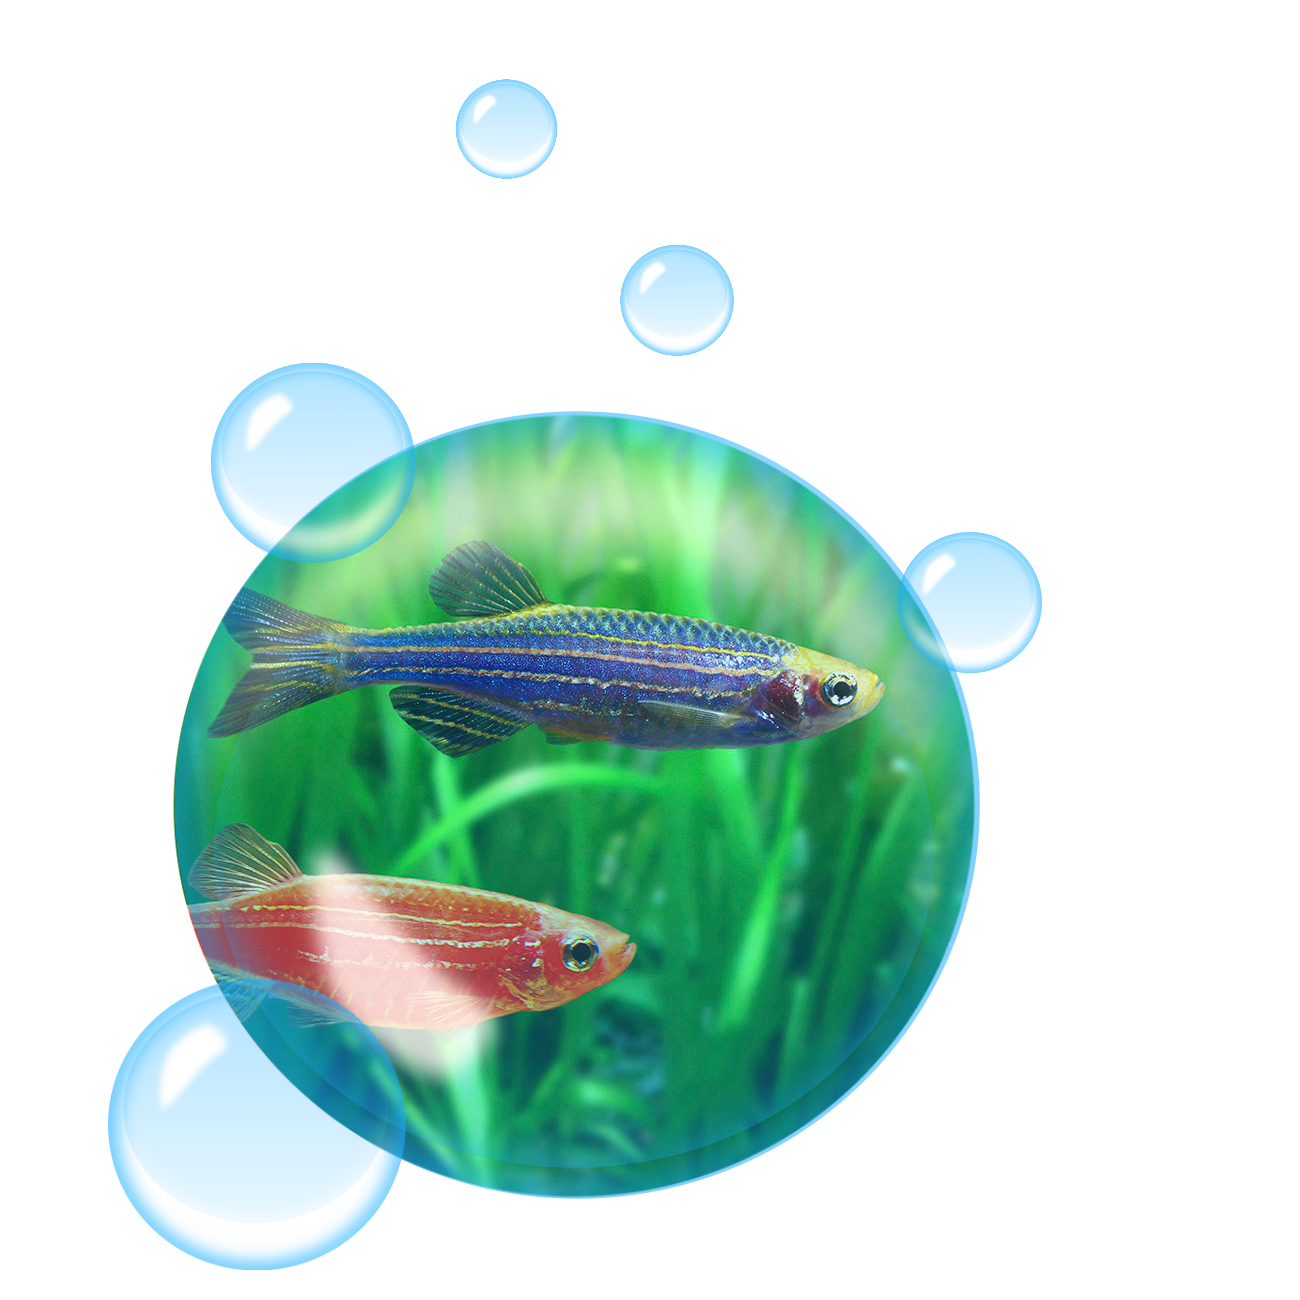

In [10]:
from PIL import Image

im = Image.open('Bin/landing_photo.png')

# crop 200px around the image
crop_px = 400
hor_move = 75
ver_move = -35
im = im.crop((crop_px+hor_move, crop_px+ver_move, im.width - crop_px+hor_move, im.height - crop_px+ver_move))

# save
im.save('Bin/landing_photo_cropped.png')

im